# Topological fingerprinting

This notebook gives an example of how to use the topological fingerprinting method.

The tracks used in this example are available here: [Track 1](https://pixabay.com/music/beats-jazzy-abstract-beat-11254/), [Track 2](https://pixabay.com/music/future-bass-powerful-beat-121791/).


In [2]:
import re 
import os
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import gudhi as gd
import markov_clustering as mc
import networkx as nx
import random


from audioId.core import audio, spectrogram
from audioId.pipeline import window_to_ph_vector
from audioId.pipeline import fingerprint_audio, compare_audios, get_matrix_from_dict, get_windows_from_audio
from audioId.pipeline.match import get_delta_t_matching, get_error_from_matching

from audioId.ph import filtrations, ph
from audioId.ph.vectorization import BettiCurveExact
from audioId.transformations.transformation import MyTransformer, NoiseTransformer

## Load a song and extract a clip

In [3]:
AUDIO_DIR = "./../data"; track_name = "apextwin.mp3"
track1 = audio.Audio.from_file(f"{AUDIO_DIR}/{track_name}")
#song1.display() #not displaying in order not to share the track!

In [4]:
clip1 = track1.extract(310., 340.)
#clip1.display()

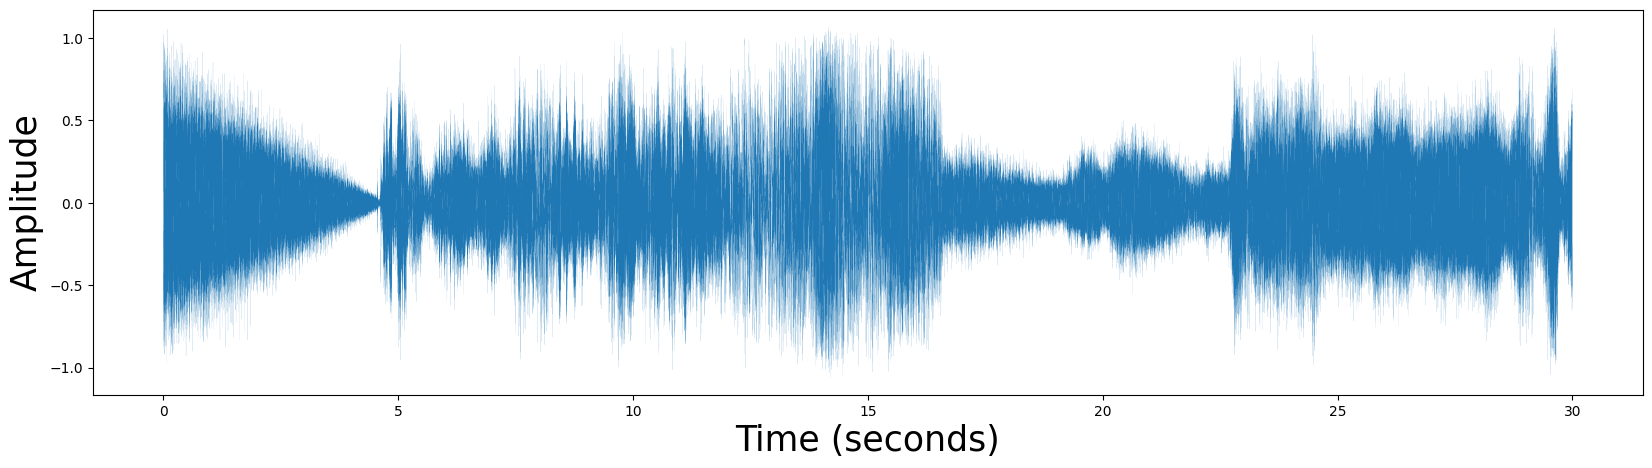

In [5]:
t0, t1 = 0., 30.; arr = clip1.values
fig = plt.figure(figsize = (20,5))
plt.plot(np.linspace(t0, t1, arr.shape[0]), arr, linewidth = 0.05)
_ = plt.xlabel('Time (seconds)', fontsize = 25)
_ = plt.ylabel('Amplitude', fontsize = 25)

### Compute a spectrogram
We illustrate the difference between a standard, Short-Time Fourier Transform spectrogram, and the MelSpectrogram.

C:\Users\santi\anaconda3\envs\audioId\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


[<Axes: title={'center': 'log-frequency spectrogram'}, xlabel='Time (s)', ylabel='Hz'>]

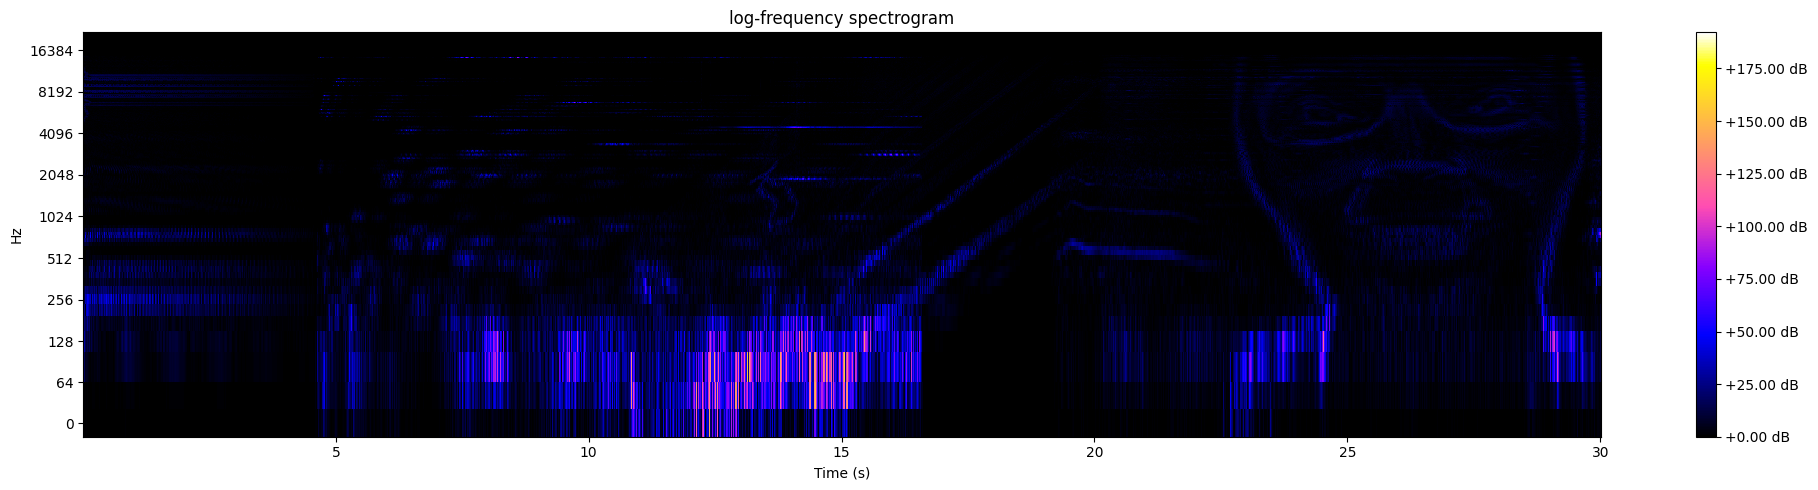

In [6]:
spec_stft = spectrogram.STFT.from_audio(clip1)
spec_stft.display()

[<Axes: title={'center': 'mel-frequency spectrogram'}, xlabel='Time (s)', ylabel='Hz'>]

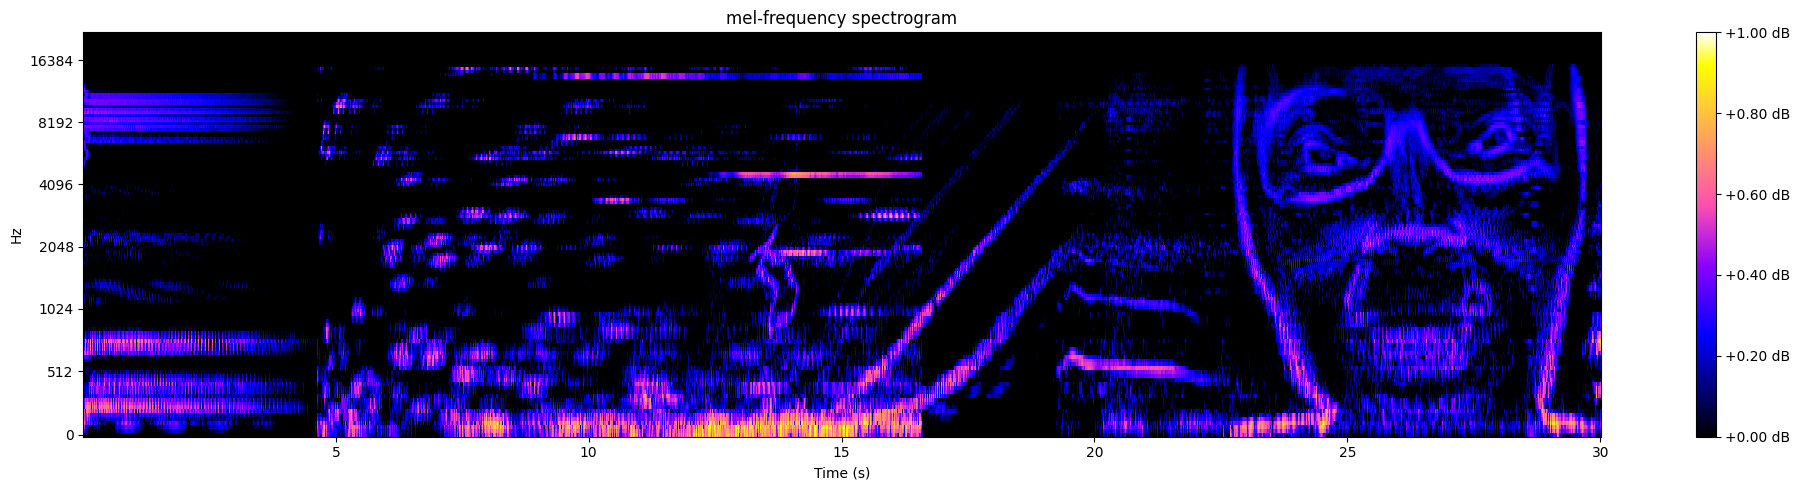

In [7]:
spectrogram.MelSpectrogram.from_audio(clip1).amplitude_to_db().normalize().display()

In [8]:
spec_stft.spec.shape

(513, 5168)

## Fingerprinting and comparing tracks
We first compute the fingerprint of a single window. Then, we use the `audioId.pipeline.fingerprint_audio` method to compute fingerprints.


In [11]:
fingerprint_params = dict(
    spectrogramFct=spectrogram.MelSpectrogram,
    filter_fct=filtrations.intensity,
    compute_ph=ph.compute_ph_super_level,
    vect={0: BettiCurveExact(True), 1: BettiCurveExact(True)}
)
lambda_value = 0.3; weights = np.array([lambda_value, 1.-lambda_value])

In [10]:
windows1 = get_windows_from_audio(clip1, spectrogram.MelSpectrogram)
key = (2.4,3.4)

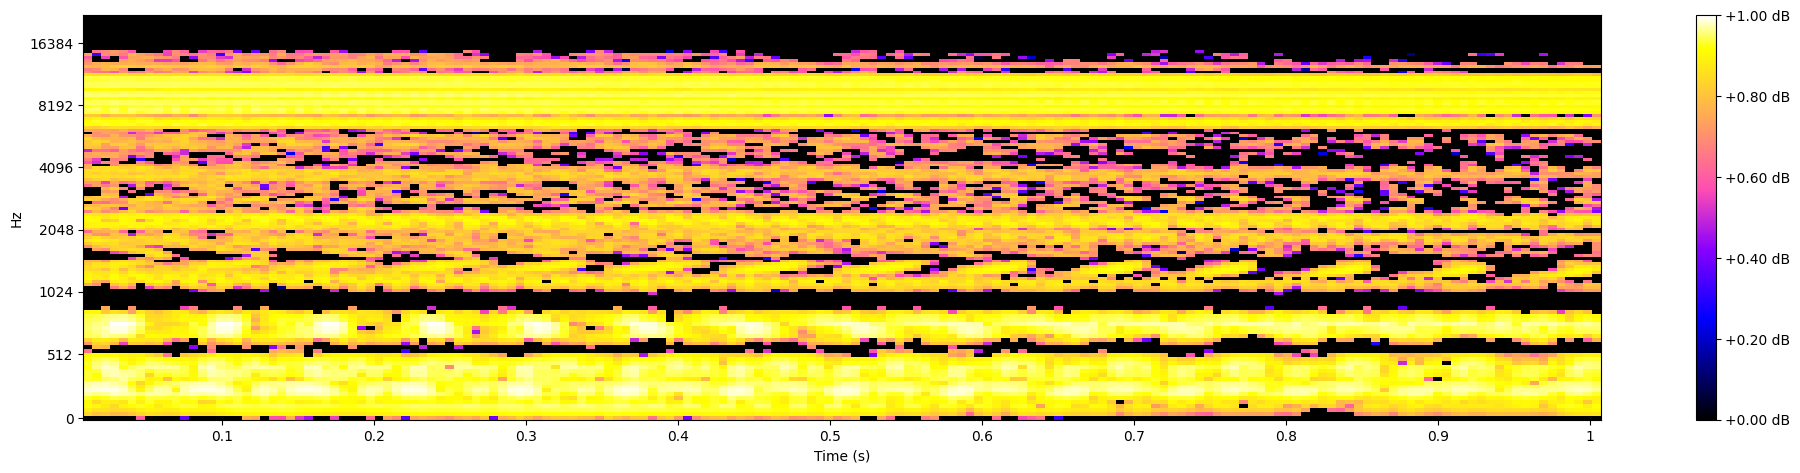

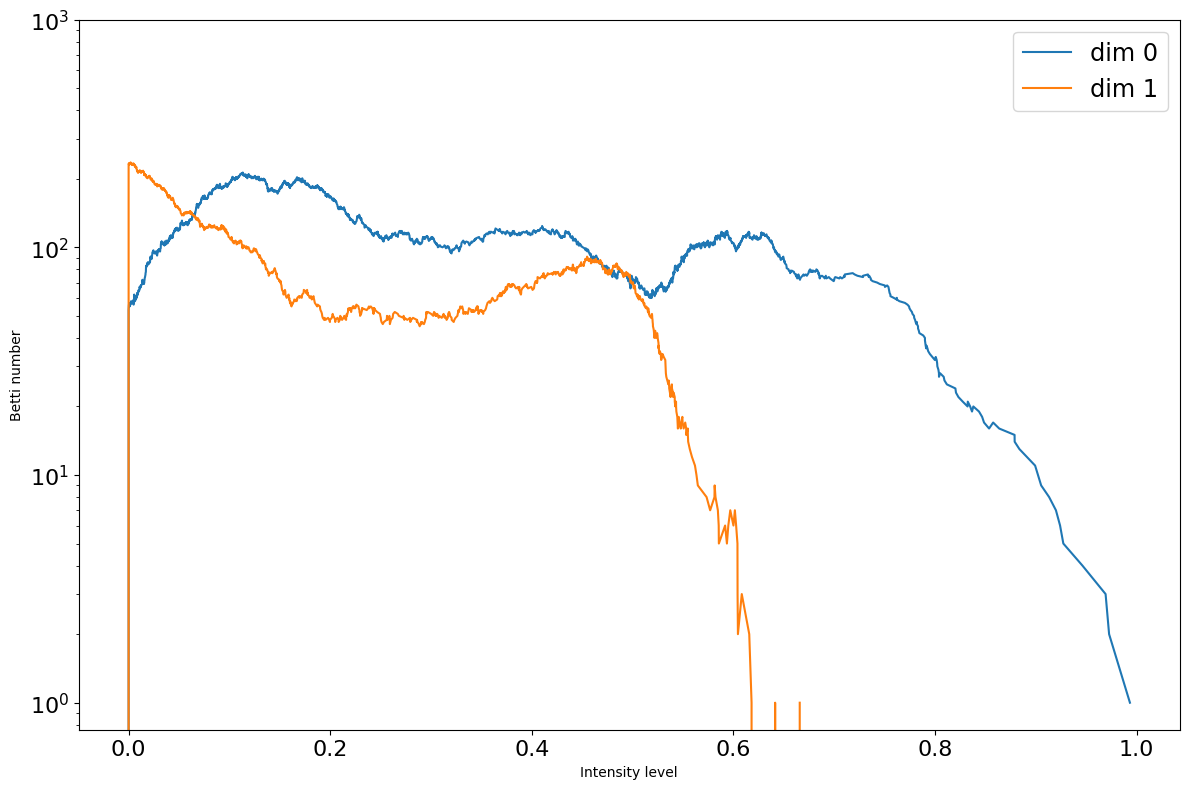

In [11]:
windows1[key].amplitude_to_db().normalize().display()
plt.title('')
bc1 = window_to_ph_vector(windows1[key], compute_ph=fingerprint_params["compute_ph"],
                         filter_fct=fingerprint_params["filter_fct"],
                         vect=fingerprint_params["vect"])

fig, ax = plt.subplots(1, 1, figsize=(12,8),)
for dim, s in zip(range(2), ['-', '-']):
    ax.semilogy(bc1[dim][0], bc1[dim][1], s, label = 'dim {0}'.format(dim))
ax.set_ylim(top=1000)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Betti number')
plt.xlabel('Intensity level')
plt.legend(fontsize='xx-large')
plt.tight_layout()

### Load a second track and compare the two

In [12]:
track_name_2 = "Taylor Swift - Shake It Off.mp3"
track2 = audio.Audio.from_file(f"{AUDIO_DIR}/{track_name_2}")
clip2 = track2.extract(5., 35.)
#clip2.display()

In [13]:
windows2 = get_windows_from_audio(clip2, spectrogram.MelSpectrogram)
key = (2.4,3.4)

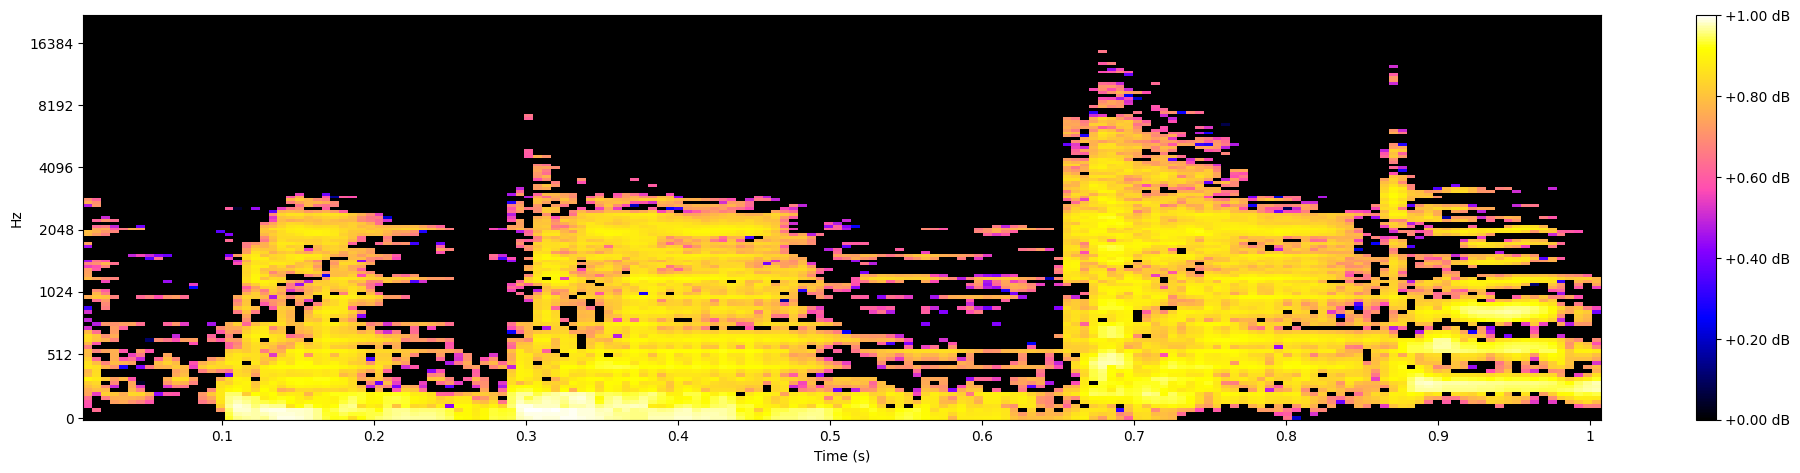

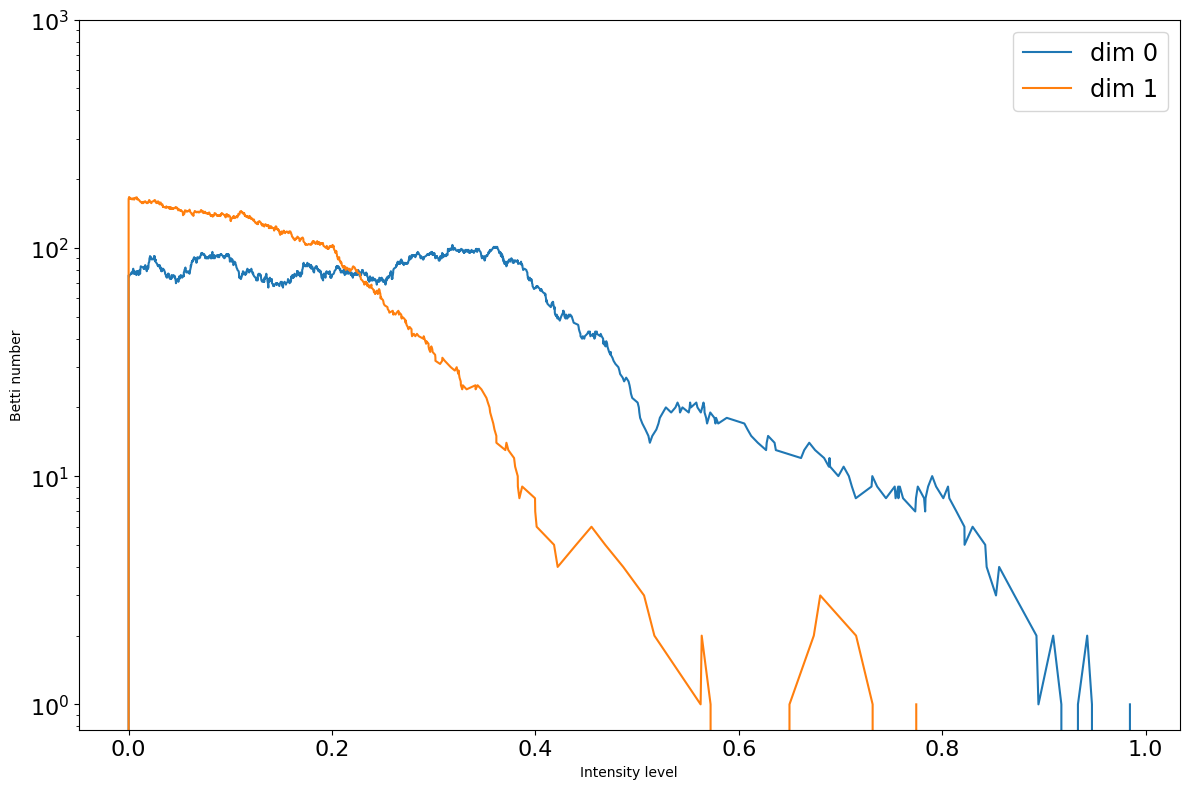

In [14]:
windows2[key].amplitude_to_db().normalize().display()
plt.title('')
bc2 = window_to_ph_vector(windows2[key], compute_ph=fingerprint_params["compute_ph"],
                         filter_fct=fingerprint_params["filter_fct"],
                         vect=fingerprint_params["vect"])

fig, ax = plt.subplots(1, 1, figsize=(12,8),)
for dim, s in zip(range(2), ['-', '-']):
    ax.semilogy(bc2[dim][0], bc2[dim][1], s, label = 'dim {0}'.format(dim))
ax.set_ylim(top=1000)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Betti number')
plt.xlabel('Intensity level')
plt.legend(fontsize='xx-large')
plt.tight_layout()

In [41]:
(gd.bottleneck_distance(ph.compute_ph(fingerprint_params["filter_fct"](windows1[key].spec), True)['complex'].persistence_intervals_in_dimension(0),
                       ph.compute_ph(fingerprint_params["filter_fct"](windows2[key].spec), True)['complex'].persistence_intervals_in_dimension(0),
                       0.01)+gd.bottleneck_distance(ph.compute_ph(fingerprint_params["filter_fct"](windows1[key].spec), True)['complex'].persistence_intervals_in_dimension(1),
                       ph.compute_ph(fingerprint_params["filter_fct"](windows2[key].spec), True)['complex'].persistence_intervals_in_dimension(1),
                       0.01))/2


0.17079359244915193

In [9]:
folder_path = "./../tracks"

tracks_names = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
windows_tracks = {}
print(tracks_names)
key = (2.4,3.4)
for name in tracks_names:
    track = audio.Audio.from_file(f"{folder_path}/{name}")
    clip = track.extract(35., 95.)
    #clip2.display()
    windows = get_windows_from_audio(clip, spectrogram.MelSpectrogram)
    windows_tracks[name] = windows


['Gorillaz - Feel Good Inc. (Official Video).mp3', 'Nirvana - Smells Like Teen Spirit (Official Music Video).mp3', 'Queens Of The Stone Age - Go With The Flow (Official Music Video).mp3', "Red Hot Chili Peppers - Can't Stop [Official Music Video].mp3", 'Sabrina Carpenter - Please Please Please (Official Video).mp3', 'Selena Gomez & The Scene - Love You Like A Love Song.mp3', 'Shakira - Ojos Así (Official HD Video).mp3', 'System Of A Down - Toxicity (Official HD Video).mp3', 'Taylor Swift - Bad Blood ft. Kendrick Lamar.mp3']


In [15]:
n_tracks = len(tracks_names)
distance_matrix = np.zeros((n_tracks, n_tracks))  #i-esima fila/columna corresponde al iesimo track en tracks_names
for i in range(len(windows_tracks.keys())):
    for j in range(i+1,len(windows_tracks.keys())):
        windows_i = windows_tracks[tracks_names[i]]
        windows_j = windows_tracks[tracks_names[j]]
        distance_matrix[i,j] = (gd.bottleneck_distance(ph.compute_ph(fingerprint_params["filter_fct"](windows_i[key].spec), True)['complex'].persistence_intervals_in_dimension(0),
                           ph.compute_ph(fingerprint_params["filter_fct"](windows_i[key].spec), True)['complex'].persistence_intervals_in_dimension(0),
                           0.01)+gd.bottleneck_distance(ph.compute_ph(fingerprint_params["filter_fct"](windows_j[key].spec), True)['complex'].persistence_intervals_in_dimension(1),
                           ph.compute_ph(fingerprint_params["filter_fct"](windows_j[key].spec), True)['complex'].persistence_intervals_in_dimension(1),
                           0.01))*100
        distance_matrix[j,i] = distance_matrix[i,j]
print(distance_matrix)

[[0.         1.29248219 0.9620414  0.85011164 0.93510952 0.98845041
  0.87715701 1.14167931 0.87172935]
 [1.29248219 0.         1.5024776  1.39054784 1.47554572 1.52888661
  1.4175932  1.6821155  1.41216554]
 [0.9620414  1.5024776  0.         0.97816896 1.06316684 1.11650773
  1.00521432 1.26973662 0.99978666]
 [0.85011164 1.39054784 0.97816896 0.         1.44439889 1.49773979
  1.38644638 1.65096868 1.38101872]
 [0.93510952 1.47554572 1.06316684 1.44439889 0.         1.28071721
  1.1694238  1.4339461  1.16399614]
 [0.98845041 1.52888661 1.11650773 1.49773979 1.28071721 0.
  0.87327658 1.13779888 0.86784892]
 [0.87715701 1.4175932  1.00521432 1.38644638 1.1694238  0.87327658
  0.         1.57943218 1.30948222]
 [1.14167931 1.6821155  1.26973662 1.65096868 1.4339461  1.13779888
  1.57943218 0.         1.55334787]
 [0.87172935 1.41216554 0.99978666 1.38101872 1.16399614 0.86784892
  1.30948222 1.55334787 0.        ]]


TypeError: unsupported operand type(s) for /: 'list' and 'int'

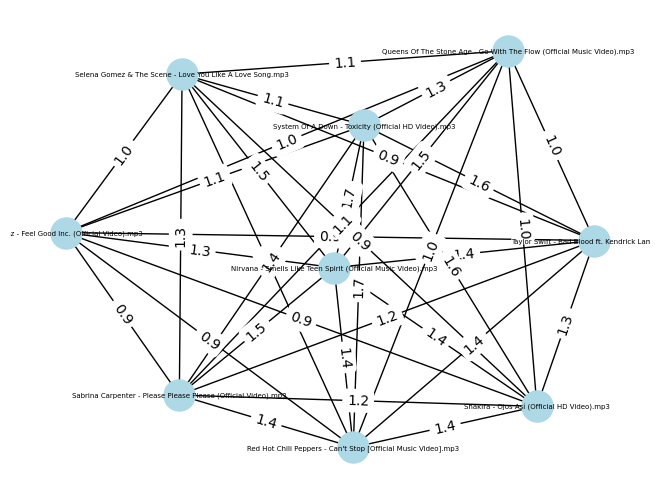

In [16]:
# Crear un grafo vacío
G = nx.Graph()


# Agregar nodos y aristas con pesos basados en la matriz de distancias
n_nodos = len(distance_matrix)
for i in range(n_nodos):
    for j in range(i + 1, n_nodos):  # Solo la mitad superior si es simétrica
        if distance_matrix[i, j] > 0:  # Ignora las distancias cero (auto-lazos)
            G.add_edge(i, j, weight=distance_matrix[i, j])
G = nx.relabel_nodes(G, dict(zip(range(0,n_tracks),tracks_names)))    

# Dibujar el grafo
pos = nx.spring_layout(G)  # Usamos un layout por resorte
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]  # Obtener pesos para las aristas

# Dibujar nodos y aristas
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=5)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f"{w['weight']:.1f}" for i, j, w in edges})
nx.draw_networkx_edges(G, pos, width=(weights/10))  # Ajusta el grosor de las aristas

plt.title("Grafo a partir de la matriz de distancias")
plt.show()

[(0, 1, 2, 3, 4, 5, 6, 7, 8)]


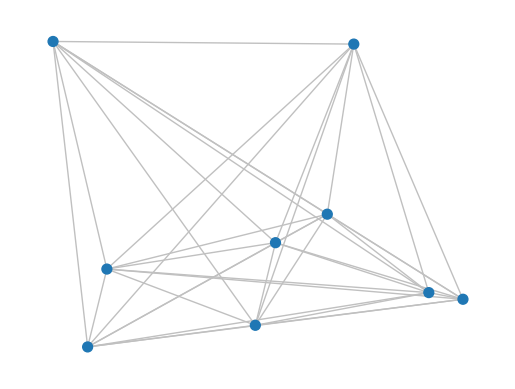

In [31]:
result = mc.run_mcl(distance_matrix,inflation=2.9)           # run MCL with default parameters
clusters = mc.get_clusters(result) 
print(clusters)# get clusters
positions = {i:(random.random() * 2 - 1, random.random() * 2 - 1) for i in range(n_nodos)}

mc.draw_graph(distance_matrix, clusters, pos=positions, node_size=50, with_labels=False, edge_color="silver")


In [28]:
print(len(bc1[0][0]), len(bc1[0][1]))

NameError: name 'bc1' is not defined

In [31]:
print(len(bc2[0][0]), len(bc2[0][1]))

1562 1562


### Compare the fingerprints of the two clips

In [75]:
comparison_12 = compare_audios(clip1, clip2, **fingerprint_params)

In [16]:
distances, keys_1, keys_2 = get_matrix_from_dict(comparison_12, windows1, windows2)
d = {'distances': distances, 'keys_1': keys_1, 'keys_2': keys_2}

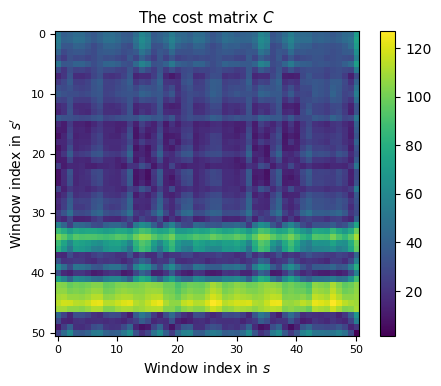

In [17]:
dist = np.array(d["distances"])
cost = np.dot(dist, weights)

plt.figure(figsize=(5,4))
plt.imshow(cost)
plt.title('The cost matrix $C$', fontsize = 11)
plt.xlabel('''Window index in $s$''', fontsize = 10)
plt.ylabel('''Window index in $s'$''', fontsize = 10)
_ = plt.colorbar()
plt.tight_layout()
_ = plt.xticks(fontsize = 8)
_ = plt.yticks(fontsize = 8)

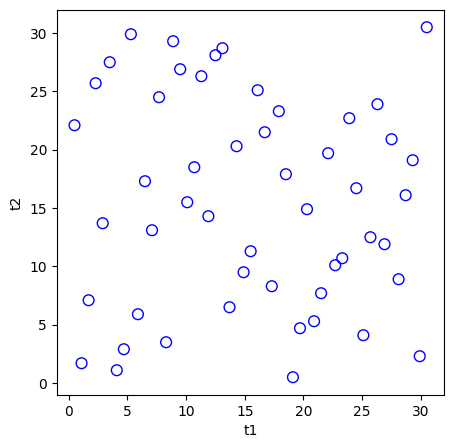

In [18]:
matching_delta_t = get_delta_t_matching(d)
plt.figure(figsize=(5,5))
plt.scatter(matching_delta_t[0], matching_delta_t[1] , s=60, marker='o', edgecolors='b', facecolors='none')
_ = plt.ylabel("t2")
_ = plt.xlabel("t1")

In [19]:
get_error_from_matching(matching_delta_t)

np.float64(1.0958083080427465)

## Obfuscate one of the clips
We obfuscate the first clip, creating a 'positive pair' and we repeat the fingerprinting and comparison process.

In [76]:
clip1.to_file("./../data/clip1.wav")

In [26]:
available_obfuscation_types = ['lowpass', 'highpass', 'pitch', 'tempo', 'whitenoise', 'pinknoise', 'reverb']
def get_transformer(obfuscation_type, degree):
    if obfuscation_type in ['whitenoise', 'pinknoise']:
        return NoiseTransformer(degree=degree, noise_type=obfuscation_type)
    else:
        m = MyTransformer()
        fct = getattr(m, obfuscation_type)
        return fct(degree)

obfuscation_name = "pitch"; degree = 1.3
#obfuscation_name = "whitenoise"; degree = 0.3
#obfuscation_name = "highpass"; degree = 100
transformer = get_transformer(obfuscation_name, degree)
#transformer.apply("clip1", AUDIO_DIR+"/", f"clip1_{obfuscation_name}", AUDIO_DIR+"/")
clip1_obfuscated_pitch = audio.Audio.from_file(f"{AUDIO_DIR}/clip1_{obfuscation_name}.wav")

In [27]:
available_obfuscation_types = ['lowpass', 'highpass', 'pitch', 'tempo', 'whitenoise', 'pinknoise', 'reverb']
def get_transformer(obfuscation_type, degree):
    if obfuscation_type in ['whitenoise', 'pinknoise']:
        return NoiseTransformer(degree=degree, noise_type=obfuscation_type)
    else:
        m = MyTransformer()
        fct = getattr(m, obfuscation_type)
        return fct(degree)

obfuscation_name = "whitenoise"; degree = 0.3
#obfuscation_name = "highpass"; degree = 100
transformer = get_transformer(obfuscation_name, degree)
#transformer.apply("clip1", AUDIO_DIR+"/", f"clip1_{obfuscation_name}", AUDIO_DIR+"/")
clip1_obfuscated_whitenoise = audio.Audio.from_file(f"{AUDIO_DIR}/clip1_{obfuscation_name}.wav")

In [28]:
available_obfuscation_types = ['lowpass', 'highpass', 'pitch', 'tempo', 'whitenoise', 'pinknoise', 'reverb']
def get_transformer(obfuscation_type, degree):
    if obfuscation_type in ['whitenoise', 'pinknoise']:
        return NoiseTransformer(degree=degree, noise_type=obfuscation_type)
    else:
        m = MyTransformer()
        fct = getattr(m, obfuscation_type)
        return fct(degree)

obfuscation_name = "highpass"; degree = 100
transformer = get_transformer(obfuscation_name, degree)
#transformer.apply("clip1", AUDIO_DIR+"/", f"clip1_{obfuscation_name}", AUDIO_DIR+"/")
clip1_obfuscated_highpass = audio.Audio.from_file(f"{AUDIO_DIR}/clip1_{obfuscation_name}.wav")

In [29]:
available_obfuscation_types = ['lowpass', 'highpass', 'pitch', 'tempo', 'whitenoise', 'pinknoise', 'reverb']
def get_transformer(obfuscation_type, degree):
    if obfuscation_type in ['whitenoise', 'pinknoise']:
        return NoiseTransformer(degree=degree, noise_type=obfuscation_type)
    else:
        m = MyTransformer()
        fct = getattr(m, obfuscation_type)
        return fct(degree)

obfuscation_name = "reverb"; degree = 1.3
#obfuscation_name = "whitenoise"; degree = 0.3
#obfuscation_name = "highpass"; degree = 100
transformer = get_transformer(obfuscation_name, degree)
transformer.apply("clip1", AUDIO_DIR+"/", f"clip1_{obfuscation_name}", AUDIO_DIR+"/")
clip1_obfuscated_reverb = audio.Audio.from_file(f"{AUDIO_DIR}/clip1_{obfuscation_name}.wav")

output_file: ./../data/clip1_reverb.wav already exists and will be overwritten on build


Could not remove ./../data/clip1.wav
Could not remove ./../data/clip1_reverb.wav


In [30]:
obfuscations = [clip1_obfuscated_pitch, clip1_obfuscated_whitenoise,clip1_obfuscated_highpass, clip1_obfuscated_reverb]
n_nodos = len(obfuscations)+1
distancias = np.zeros((n_nodos, n_nodos))

for i in range(0,len(obfuscations)):
    print(obfuscations[i])
    distancias[i,0]=compare_audios(clip1, obfuscations[i], **fingerprint_params)
    for j in range(i,len(obfuscations)):
        distancias[i,j] = compare_audios(obfuscations[j], obfuscations[i], **fingerprint_params)


TypeError: float() argument must be a string or a number, not 'collections.OrderedDict'

In [ ]:
print(distancias)

In [ ]:
distances, keys_1, keys_2 = get_matrix_from_dict(comparison_12, windows1, windows2)
d = {'distances': distances, 'keys_1': keys_1, 'keys_2': keys_2}
dist = np.array(d["distances"])
cost = np.dot(dist, weights)

plt.figure(figsize=(5,4))
plt.imshow(cost)
plt.title('The cost matrix $C$', fontsize = 11)
plt.xlabel('''Window index in $s$''', fontsize = 10)
plt.ylabel('''Window index in $s'$''', fontsize = 10)
_ = plt.colorbar()
plt.tight_layout()
_ = plt.xticks(fontsize = 8)
_ = plt.yticks(fontsize = 8)

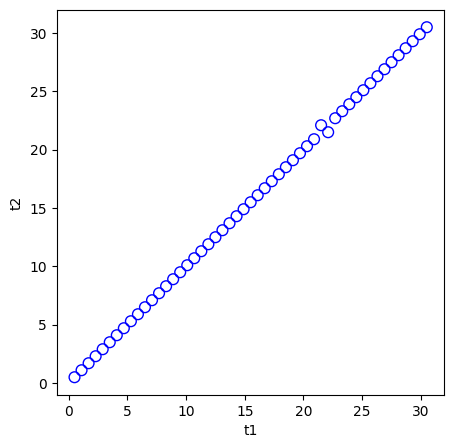

In [28]:
matching_delta_t = get_delta_t_matching(d)
plt.figure(figsize=(5,5))
plt.scatter(matching_delta_t[0], matching_delta_t[1] , s=60, marker='o', edgecolors='b', facecolors='none')
_ = plt.ylabel("t2")
_ = plt.xlabel("t1")

In [29]:
error_rever = get_error_from_matching(matching_delta_t)

np.float64(0.0)

[<Axes: title={'center': 'log-frequency spectrogram'}, xlabel='Time (s)', ylabel='Hz'>]

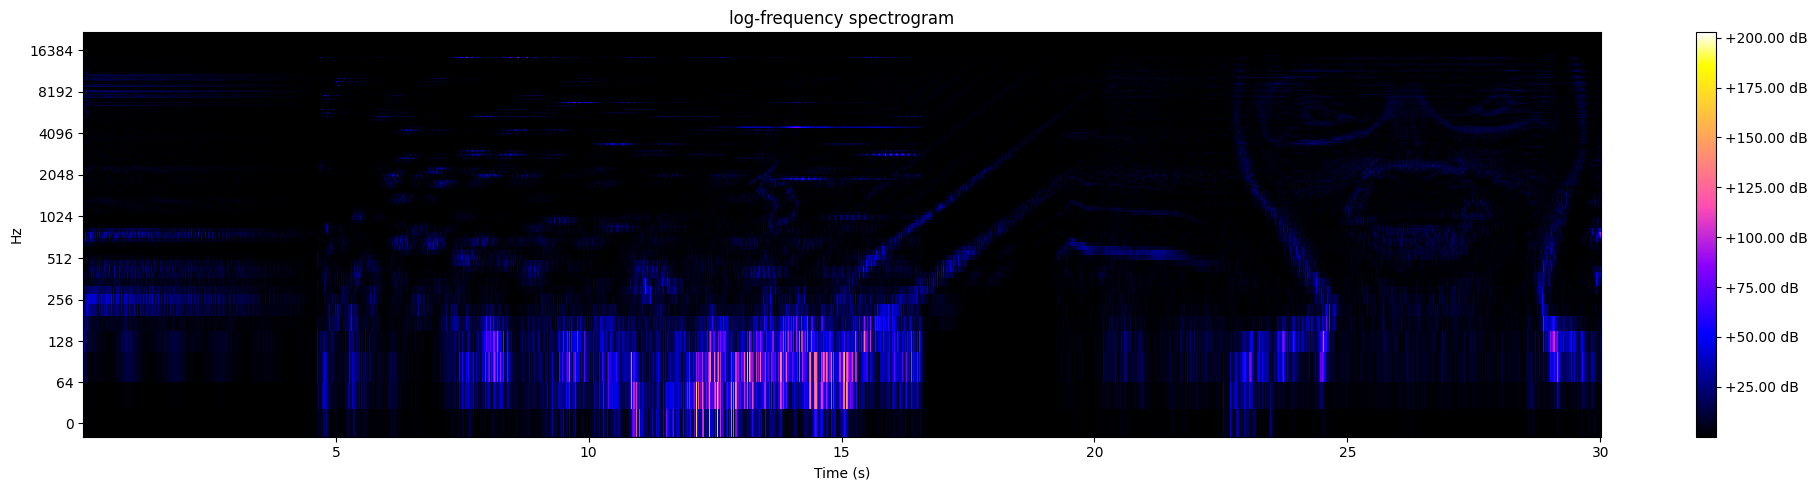

In [31]:
spec_stft = spectrogram.STFT.from_audio(clip1_obfuscated_reverb)
spec_stft.display()

[<Axes: title={'center': 'mel-frequency spectrogram'}, xlabel='Time (s)', ylabel='Hz'>]

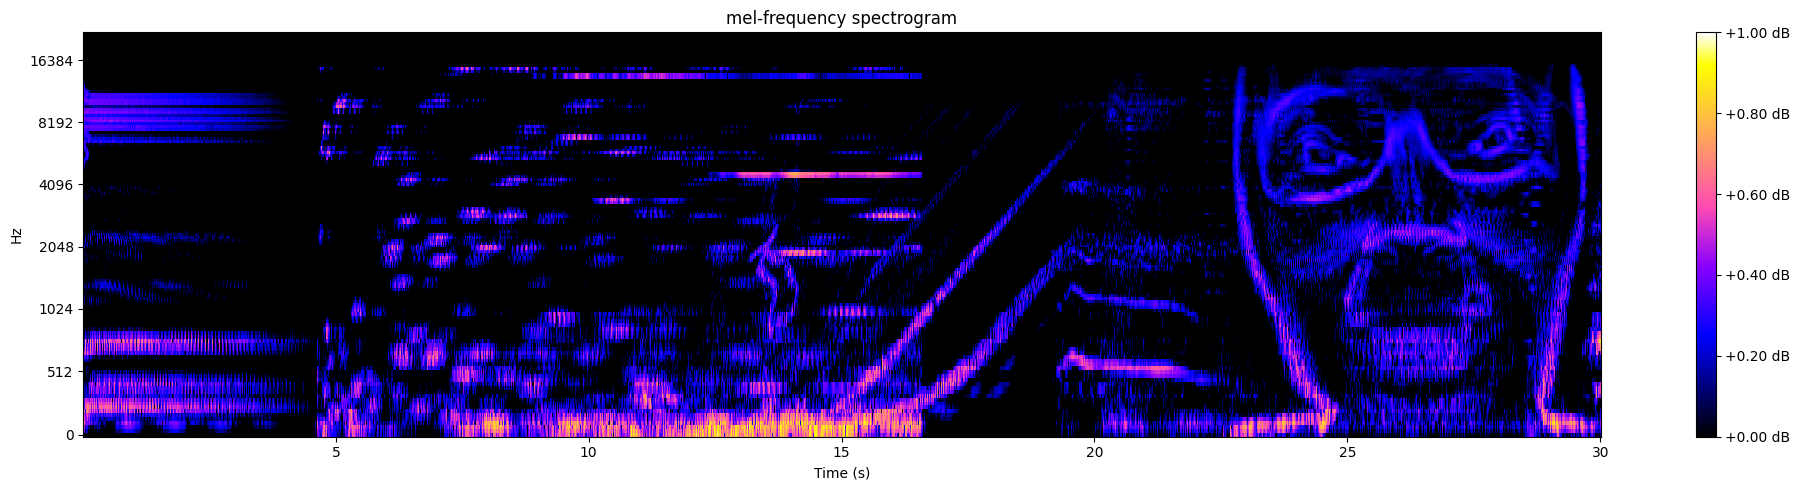

In [32]:
spectrogram.MelSpectrogram.from_audio(clip1_obfuscated_reverb).amplitude_to_db().normalize().display()